# Einführung: Was sind Agenten?

In einem LLM-gesteuerten autonomen Agentensystem fungiert das LLM als Gehirn des Agenten, ergänzt durch mehrere wichtige Komponenten:

- Planung
    - Unterziele und Zerlegung: Der Agent zerlegt große Aufgaben in kleinere, handhabbare Unterziele, um komplexe Aufgaben effizient zu bewältigen.
    - Reflexion und Verfeinerung: Der Agent kann Selbstkritik und Selbstreflexion über vergangene Aktionen durchführen, aus Fehlern lernen und diese für zukünftige Schritte verfeinern, wodurch die Qualität der Endergebnisse verbessert wird.
- Gedächtnis
    - Kurzzeitgedächtnis: Ich würde das gesamte In-Context-Learning (siehe Prompt Engineering) als Nutzung des Kurzzeitgedächtnisses des Modells betrachten, um zu lernen.
    - Langzeitgedächtnis: Dies ermöglicht dem Agenten, (unendliche) Informationen über längere Zeiträume zu speichern und abzurufen, oft durch die Nutzung eines externen Vektorspeichers und schneller Abrufmethoden.
- Werkzeugnutzung
    - Der Agent lernt, externe APIs aufzurufen, um zusätzliche Informationen zu erhalten, die in den Modellgewichten fehlen (oft schwer nach dem Pre-Training zu ändern), einschließlich aktueller Informationen, Code-Ausführungsfähigkeiten, Zugriff auf proprietäre Informationsquellen und mehr.


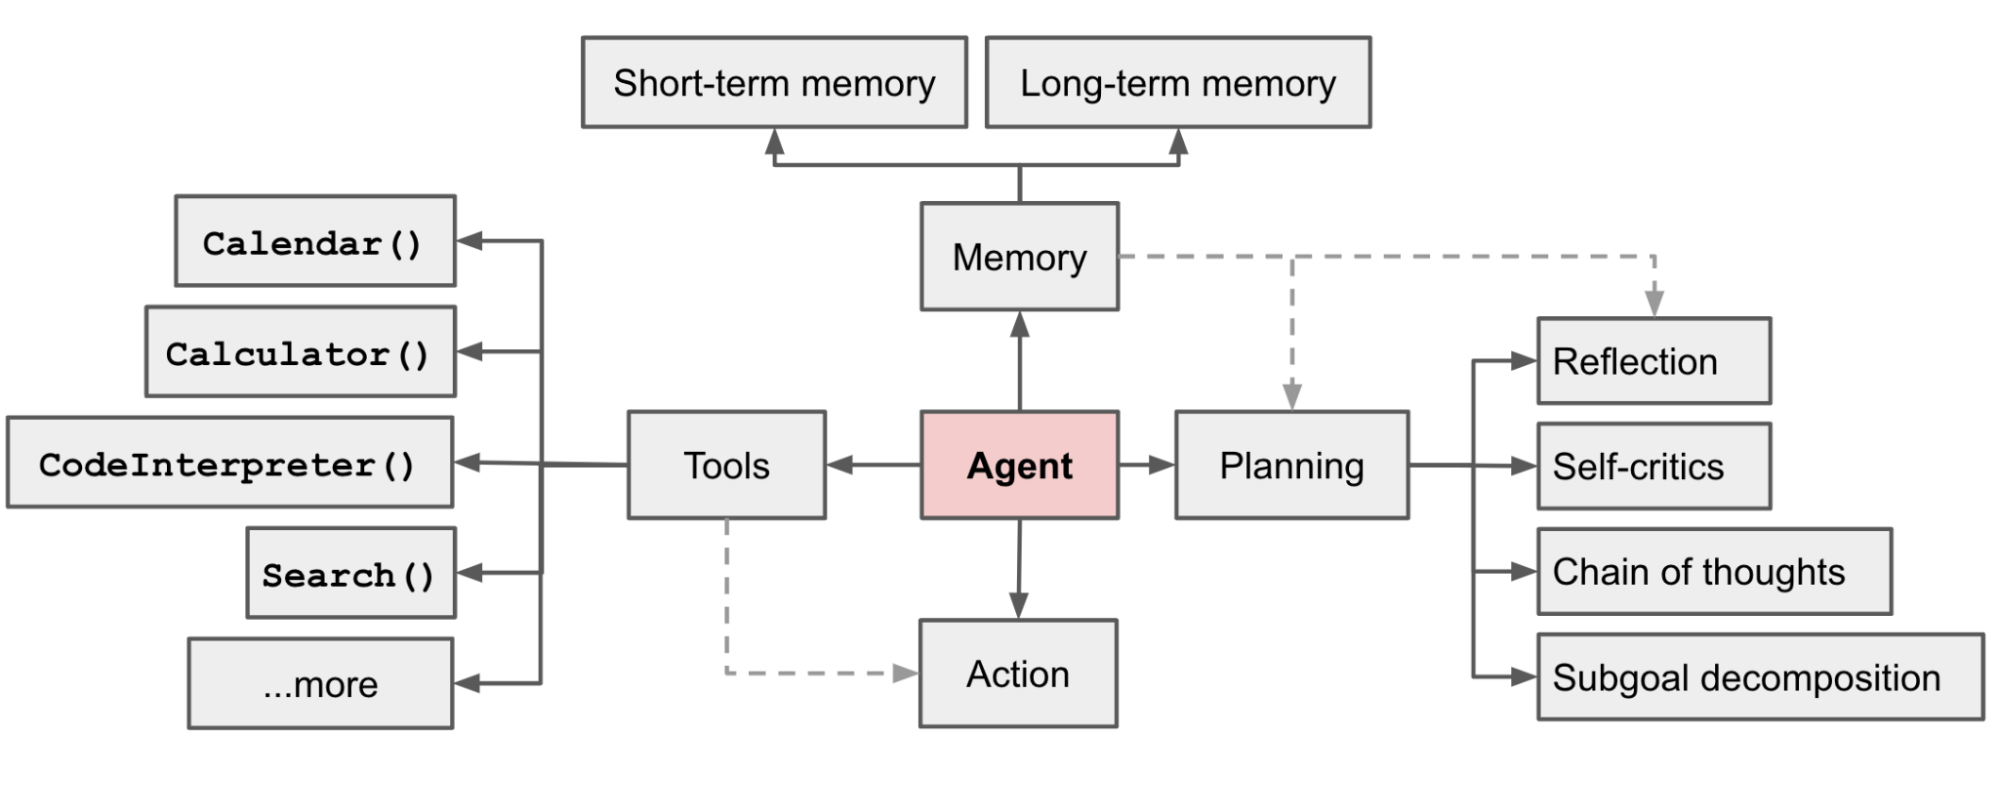

Quelle:  [LLM Powered Autonomous Agents - Lilian Weng](https://lilianweng.github.io/posts/2023-06-23-agent/)

## Wie helfen uns Agenten im Open Data Kontext?

Open Data Portale sind nicht für alle Nutzer:innen gleichermaßen zugänglich. 
Daten verstecken sich hinter komplizierten Suchmasken, sind in unstrukturierten Formaten oder nur per API zugänglich.
Agenten können uns helfen, diese Informationen per natürlicher Sprache erreichbar und durchsuchbar zu machen.
In Zukunft könnten Sie vielleicht sogar einfache Analysen durchführen, um Nutzer:innen bei der Interpretation der Daten zu helfen.

## Was haben wir heute vor?

Wir wollen uns heute mit folgenden Themen beschäftigen:

- Erstellung eines einfachen Agenten mithilfe von LangGraph
- Erweiterung des Agenten um Tools zur Websuche
- Erstellen eigener Tools zum Zugriff auf das Münchner Open Data Portal

# Einfacher Agent in LangGraph

Ein ausführliches Tutorial und weitere Informationen zu LangGraph findet man auf der [Website](https://langchain-ai.github.io/langgraph/)

## Umgebung einrichten
Richten Sie Umgebungsvariablen ein und laden Sie dotenv für API-Schlüssel.

In [1]:
from dotenv import load_dotenv

# Load environment variables from a .env f*ile
load_dotenv()

True

## Agentenzustand definieren
Definieren Sie das TypedDict für den Agentenzustand, der Nachrichten im Gespräch verfolgt.

In [2]:
from typing import Annotated

from langgraph.graph.message import add_messages
from typing_extensions import TypedDict


# Define Agent State
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

## LangGraph erstellen
Erstellen Sie den Graphen mit einem Chatbot-Knoten, der Nachrichten mithilfe des OpenAI-Modells verarbeitet.

In [3]:
from langchain_openai import AzureChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph

# Initialize the StateGraph with the defined State
graph_builder = StateGraph(State)

# Initialize the ChatOpenAI model
chat_model = AzureChatOpenAI(azure_deployment="gpt-4o")

# Define the chatbot function
def _chatbot(state: State):
    return {"messages": [chat_model.invoke(state["messages"])]}

# Add nodes and edges to the graph
graph_builder.add_node("chatbot", _chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Add memory to the graph
memory_saver = MemorySaver()

# Compile the graph
graph = graph_builder.compile(checkpointer=memory_saver)

# Check if the graph was created successfully
print("LangGraph created successfully.")

LangGraph created successfully.


## Agent testen

Testen Sie den Agenten, indem Sie eine Nachricht eingeben und die Antwort überprüfen.

In [4]:
from uuid import uuid4

from langchain.schema import HumanMessage

# Define a unique thread ID for the conversation
thread_id = uuid4()

# Define a function to stream graph updates based on user input
def _stream_graph_updates(user_input: str):
    input_message = HumanMessage(content=user_input)
    input_message.pretty_print()
    for event in graph.stream({"messages": [input_message]}, config={"configurable": {"thread_id": thread_id}}):
        for value in event.values():
            for message in value["messages"]:
                message.pretty_print()

# Test the agent with a sample message
user_input = "Wie viele Datensätze gibt es im Münchner Open Data Portal?"
_stream_graph_updates(user_input)

================================ Human Message =================================

Wie viele Datensätze gibt es im Münchner Open Data Portal?
================================== Ai Message ==================================

Mit Stand bis Oktober 2023 variiert die Anzahl der Datensätze im Münchner Open Data Portal, da regelmäßig neue Datensätze hinzugefügt und alte aktualisiert oder entfernt werden. Um die aktuellste Anzahl der verfügbaren Datensätze zu erfahren, empfehle ich, direkt das Münchner Open Data Portal zu besuchen und dort nach der aktuellen Statistik oder Datenübersicht zu suchen.


## Graph visualisieren

Der Graph zeigt den Ablauf des Agenten und die Knoten, die er durchläuft.

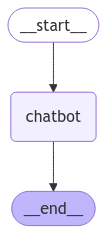

In [5]:
from IPython.display import Image, display

# Generate the graph visualization as a PNG image
img = graph.get_graph().draw_mermaid_png()

# Display the image in the notebook
display(Image(img))

# Erweiterung des Agenten um Tools zur Websuche

Bis jetzt haben wir nur ein einfaces Sprachmodell mit Memory erstellt. Um nun einen echten Agenten zu bauen, brauchen wir eine Möglichkeit, Informationen aus dem Web zu holen. Dafür werden wir eine Websuche hinzufügen.
Dazu nutzen wir das Paket `duckduckgo_search` und bauen damit eine Funktion, die dann unserem Agenten als Tool mitgegeben wird.

In [6]:
from duckduckgo_search import DDGS
from langchain_core.tools import tool

ddgs = DDGS()

# Define a function to search for information using DuckDuckGo
@tool
def search_duckduckgo(query: str):
    """Search for information using the DuckDuckGo web search engine."""
    return ddgs.text(query, region="de-de")


search_duckduckgo.invoke("Wie viele Datensätze gibt es im Münchner Open Data Portal?")

[{'title': 'Willkommen - Open Data Portal München',
  'href': 'https://opendata.muenchen.de/',
  'body': 'Das Open-Data-Portal ist eine Plattform zur Bereitstellung offener Verwaltungsdaten der Landeshauptstadt München. Weitere Informationen. Aktuelle Informationen zu Datensätzen. Sie vermissen...'},
 {'title': 'Datensätze des Open Data Portals München - Open Data München',
  'href': 'https://opendata.muenchen.de/de/dataset/datensaetze-des-open-data-portals-muenchen',
  'body': 'Dieser Datensatz umfasst eine Liste aller Datensätze des Open Data Portals der Landeshauptstadt München (ohne Ressourcen).'},
 {'title': 'Statistik - Interaktive Anwendungen - Landeshauptstadt München',
  'href': 'https://stadt.muenchen.de/infos/statistik-interaktive-anwendungen.html',
  'body': 'Der Indikatorenatlas München enthält folgende Themenbereiche: Arbeitsmarkt, Bauen, Bevölkerung, Flächen, Gesundheit, Grundschüler*innen, Kinderbetreuung, Verkehr. Bitte beachten Sie auch die...'},
 {'title': 'Offene Da

## Neuen Websearch-Graphen erstellen

Mit dem neuen Tool können wir nun einen neuen Graphen erstellen, der die Websuche als zusätzliche Möglichkeit für den Agenten hinzufügt.
Dazu brauchen wir einen ToolNode, der das definierte Tool auch tatsächlich aufrufen kann.
Dies wird nämlich nicht direkt vom Sprachmodell übernommen.

In [7]:
from langgraph.prebuilt import ToolNode, tools_condition

# Create a new StateGraph for the chat model with the search tool
websearch_graph_builder = StateGraph(State)

# Define the tools
search_tools = [search_duckduckgo]

# Bind the search tool to the chat model
chat_model_with_search = chat_model.bind_tools(search_tools)

# Define the chatbot function
def chatbot_with_tools(state: State):
    return {"messages": [chat_model_with_search.invoke(state["messages"])]}

# Add nodes and edges to the graph
websearch_graph_builder.add_node("chatbot", chatbot_with_tools)

# Add the search tool node to the graph
tool_node = ToolNode(tools=search_tools)
websearch_graph_builder.add_node("tools", tool_node)

# Add conditional edges to the graph
websearch_graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
websearch_graph_builder.add_edge("tools", "chatbot")
websearch_graph_builder.set_entry_point("chatbot")

# Compile the graph
websearch_graph = websearch_graph_builder.compile(checkpointer=memory_saver)

## Websearch-Graph visualisieren

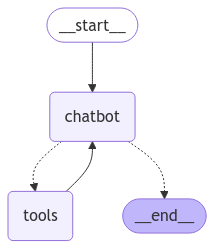

In [8]:
from IPython.display import Image, display

# Generate the graph visualization as a PNG image
img = websearch_graph.get_graph().draw_mermaid_png()

# Display the image in the notebook
display(Image(img))

## Websearch-Graph testen

In [9]:
# Define a unique thread ID for the conversation
tool_thread_id = uuid4()

# Define a function to stream graph updates based on user input
def _stream_websearch_graph_updates(user_input: str):
    input_message = HumanMessage(content=user_input)
    input_message.pretty_print()
    for event in websearch_graph.stream({"messages": [input_message]}, config={"configurable": {"thread_id": tool_thread_id}}):
        for value in event.values():
            for message in value["messages"]:
                message.pretty_print()

# Test the agent with a sample message
user_input = "Wie viele Datensätze gibt es im Münchner Open Data Portal?"
_stream_websearch_graph_updates(user_input)

================================ Human Message =================================

Wie viele Datensätze gibt es im Münchner Open Data Portal?
================================== Ai Message ==================================
Tool Calls:
  search_duckduckgo (call_q7nXm7Xo3AxV0UqXrNVX1Qtc)
 Call ID: call_q7nXm7Xo3AxV0UqXrNVX1Qtc
  Args:
    query: site:opendata.muenchen.de Anzahl Datensätze
================================= Tool Message =================================
Name: search_duckduckgo

[{"title": "Willkommen - Open Data Portal München", "href": "https://opendata.muenchen.de/", "body": "Aktuelle Informationen zu Datensätzen. Schneller Start der Datenanalyse mit dem Startercode (Link zu GitHub) Sie vermissen einen Datensatz? Gerne nehmen wir Ihre Anregung entgegen:..."}, {"title": "Datensätze des Open Data Portals München - Open Data München", "href": "https://opendata.muenchen.de/de/dataset/datensaetze-des-open-data-portals-muenchen", "body": "Dieser Datensatz umfasst eine Liste all

## Agent mit Tools für das Open Data Portal erweitern

Nun wollen wir den Agenten noch um eine weitere Funktion erweitern, die es ihm ermöglicht, Daten direkt aus dem Open Data Portal zu holen.
Dazu nutzen wir das Paket `ckanapi`, welches uns direkt auf die Schnittstelle des CKAN-Katalogs zugreifen lässt.

Die CKAN-Schnittstelle ist sehr mächtig und erlaubt es uns, Daten zu suchen, herunterzuladen und sogar zu analysieren.
- [zur API-Dokumentation](https://docs.ckan.org/en/2.11/api/#api-examples)
- [zum Python-Paket](https://github.com/ckan/ckanapi/blob/master/README.md#ckanapi-python-module)

In [10]:
from pprint import pprint

from ckanapi import RemoteCKAN

user_agent = "odddatahelper/0.1"
odp_muc = RemoteCKAN("https://opendata.muenchen.de/", user_agent=user_agent)

dataset_list = odp_muc.call_action("package_list")
print(f"Es gibt {len(dataset_list)} Datensätze, die ersten fünf sind:")
pprint(dataset_list[:5])

Es gibt 317 Datensätze, die ersten fünf sind:
['abfall_auto_metall_opendata',
 'abfall_betrieb_opendata',
 'abfall_elektronik_opendata',
 'abfall_gewerbemisch_opendata',
 'abfall_kompost_opendata']


## CKAN-Tools erstellen

Wir können für verschiedene Schnittstellen-Endpunkte Funktionen erstellen, die wir dann als Tools dem Agenten hinzufügen können.

In [11]:
from typing import Any, Optional


@tool
def get_dataset_count() -> int:
    """Returns the currently available number of datasets on opendata.muenchen.de"""
    datasets = odp_muc.call_action("package_list")
    return len(datasets)


@tool
def search_datasets(query: str) -> dict:
    """Search for datasets on opendata.muenchen.de"""
    search_results = odp_muc.call_action("package_search", data_dict={"q": query})
    return search_results


@tool
def call_ckan_action_api(action: str, data_dict: Optional[dict] = None) -> Any:
    """Call any action from the CKAN API of opendata.muenchen.de"""
    return odp_muc.call_action(action, data_dict)

## Neuen ODP Helper Graphen erstellen

Mit den neuen Tools können wir nun einen neuen Graphen erstellen, der die Open Data Funktionen als zusätzliche Möglichkeit für den Agenten hinzufügt.

In [12]:
# Create a new StateGraph for the chat model with the search tool
opendata_helper_graph_builder = StateGraph(State)

# Define the tools
opendata_portal_tools = [get_dataset_count, search_datasets, call_ckan_action_api]

# Bind the search tool to the chat model
chat_model_opendata_tools = chat_model.bind_tools(opendata_portal_tools)

# Define the chatbot function
def chatbot_with_tools(state: State):
    return {"messages": [chat_model_opendata_tools.invoke(state["messages"])]}

# Add nodes and edges to the graph
opendata_helper_graph_builder.add_node("chatbot", chatbot_with_tools)

# Add the search tool node to the graph
tool_node = ToolNode(tools=opendata_portal_tools)
opendata_helper_graph_builder.add_node("tools", tool_node)

# Add conditional edges to the graph
opendata_helper_graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
opendata_helper_graph_builder.add_edge("tools", "chatbot")
opendata_helper_graph_builder.set_entry_point("chatbot")

# Compile the graph
opendata_helper_graph = opendata_helper_graph_builder.compile(checkpointer=memory_saver)

## ODP-Helper testen

In [13]:
# Define a unique thread ID for the conversation
odp_thread_id = uuid4()

# Define a function to stream graph updates based on user input
def _stream_odp_graph_updates(user_input: str):
    input_message = HumanMessage(content=user_input)
    input_message.pretty_print()
    for event in opendata_helper_graph.stream({"messages": [input_message]}, config={"configurable": {"thread_id": tool_thread_id}}):
        for value in event.values():
            for message in value["messages"]:
                message.pretty_print()

# Test the agent with a sample message
user_input = "Wie viele Datensätze gibt es im Münchner Open Data Portal?"
_stream_odp_graph_updates(user_input)

================================ Human Message =================================

Wie viele Datensätze gibt es im Münchner Open Data Portal?
================================== Ai Message ==================================
Tool Calls:
  get_dataset_count (call_vdIIwpeuana7uyBeVQoA6Dh5)
 Call ID: call_vdIIwpeuana7uyBeVQoA6Dh5
  Args:
================================= Tool Message =================================
Name: get_dataset_count

317
================================== Ai Message ==================================

Im Münchner Open Data Portal gibt es derzeit 317 Datensätze.


In [14]:
_stream_odp_graph_updates("Welche Datensätze gibt es zum Thema Verkehr?")

================================ Human Message =================================

Welche Datensätze gibt es zum Thema Verkehr?
================================== Ai Message ==================================
Tool Calls:
  search_datasets (call_3BVWKoZxBXMivqXte3iK6ZQK)
 Call ID: call_3BVWKoZxBXMivqXte3iK6ZQK
  Args:
    query: Verkehr
================================= Tool Message =================================
Name: search_datasets

{"count": 91, "sort": "score desc, metadata_modified desc", "facets": {}, "results": [{"license_title": "Datenlizenz Deutschland Namensnennung 2.0", "maintainer": "Statistisches Amt", "relationships_as_object": [], "private": false, "maintainer_email": "stat.amt@muenchen.de", "num_tags": 3, "id": "040c8a8c-6934-48e6-8413-70b07f99a970", "metadata_created": "2015-01-26T13:05:58.139038", "metadata_modified": "2024-10-30T11:11:30.745206", "author": "", "author_email": "stat.amt@muenchen.de", "state": "active", "version": "", "creator_user_id": "79f4f706-d55

In [15]:
_stream_odp_graph_updates("Wie viele Datensätze wurden im Jahr 2025 veröffentlicht?")

================================ Human Message =================================

Wie viele Datensätze wurden im Jahr 2025 veröffentlicht?
================================== Ai Message ==================================
Tool Calls:
  call_ckan_action_api (call_HUScr5VKXHaCZTVpoeBdbtfW)
 Call ID: call_HUScr5VKXHaCZTVpoeBdbtfW
  Args:
    action: package_search
    data_dict: None
================================= Tool Message =================================
Name: call_ckan_action_api

{"count": 303, "sort": "score desc, metadata_modified desc", "facets": {}, "results": [{"license_title": "Datenlizenz Deutschland Namensnennung 2.0", "maintainer": "KR-GSM", "relationships_as_object": [], "private": false, "maintainer_email": "geoportal@muenchen.de", "num_tags": 3, "id": "297f0915-eb0e-44b8-b2ed-77f6d4590d7c", "metadata_created": "2023-08-02T13:23:50.562764", "metadata_modified": "2025-02-28T06:01:11.968177", "author": "KR-GSM", "author_email": "geoportal@muenchen.de", "state": "active",

In [16]:
_stream_odp_graph_updates("Wie viele Datensätze wurden vom IT-Referat veröffentlicht?")

================================ Human Message =================================

Wie viele Datensätze wurden vom IT-Referat veröffentlicht?
================================== Ai Message ==================================
Tool Calls:
  call_ckan_action_api (call_q7nXm7Xo3AxV0UqXrNVX1Qtc)
 Call ID: call_q7nXm7Xo3AxV0UqXrNVX1Qtc
  Args:
    action: package_search
    data_dict: None
================================= Tool Message =================================
Name: call_ckan_action_api

{"count": 303, "sort": "score desc, metadata_modified desc", "facets": {}, "results": [{"license_title": "Datenlizenz Deutschland Namensnennung 2.0", "maintainer": "KR-GSM", "relationships_as_object": [], "private": false, "maintainer_email": "geoportal@muenchen.de", "num_tags": 3, "id": "297f0915-eb0e-44b8-b2ed-77f6d4590d7c", "metadata_created": "2023-08-02T13:23:50.562764", "metadata_modified": "2025-02-28T06:01:11.968177", "author": "KR-GSM", "author_email": "geoportal@muenchen.de", "state": "active

In [19]:
_stream_odp_graph_updates("Welche Lizenz kommt im gesamten Open Data Portal am häufigsten vor?")

================================ Human Message =================================

Welche Lizenz kommt im gesamten Open Data Portal am häufigsten vor?
================================== Ai Message ==================================
Tool Calls:
  call_ckan_action_api (call_vxaIN8RhfWtAGtv62bRmfKlo)
 Call ID: call_vxaIN8RhfWtAGtv62bRmfKlo
  Args:
    action: license_list
================================= Tool Message =================================
Name: call_ckan_action_api

[{"status": "active", "maintainer": "", "od_conformance": "approved", "family": "", "title": "Datenlizenz Deutschland Namensnennung", "domain_data": true, "osd_conformance": "", "url": "https://www.govdata.de/dl-de/by-1-0", "is_generic": true, "is_okd_compliant": true, "is_osi_compliant": false, "domain_content": true, "domain_software": false, "id": "dl-de-by-1.0"}, {"status": "active", "maintainer": "", "od_conformance": "approved", "family": "", "title": "Datenlizenz Deutschland Namensnennung 2.0", "domain_data"

In [20]:
_stream_odp_graph_updates("Welche 5 Datensätze wurden im gesamten Portal zuletzt veröffentlicht?")

================================ Human Message =================================

Welche 5 Datensätze wurden im gesamten Portal zuletzt veröffentlicht?
================================== Ai Message ==================================
Tool Calls:
  call_ckan_action_api (call_q7nXm7Xo3AxV0UqXrNVX1Qtc)
 Call ID: call_q7nXm7Xo3AxV0UqXrNVX1Qtc
  Args:
    action: package_search
    data_dict: {'sort': 'metadata_created desc', 'rows': 5}
================================= Tool Message =================================
Name: call_ckan_action_api

{"count": 303, "sort": "metadata_created desc", "facets": {}, "results": [{"license_title": "Datenlizenz Deutschland Namensnennung 2.0", "maintainer": "wahlergebnis.kvr@muenchen.de", "relationships_as_object": [], "private": false, "maintainer_email": "wahlergebnis.kvr@muenchen.de", "num_tags": 4, "id": "2a926cfd-4bbf-4f06-8397-1716b0c4d430", "metadata_created": "2025-02-26T12:54:07.631359", "metadata_modified": "2025-02-26T14:17:21.131494", "author": 

# Ausblick

Mit diesen Tools können wir nun Agenten erstellen, die uns bei der Suche nach Informationen im Web und auf Open Data Portalen helfen können.
Mittlerweile gibt es auch schon die Möglichkeiten, Agenten mit speziellen Sandboxes auszustatten, die es ihnen erlauben, Code auszuführen und so auch Datenanalysen durchzuführen.
Diese Sandboxes sind leider aktuell meist noch in nicht selbst kontrollierten Cloud-Umgebungen, sodass die Datenhoheit nicht immer gewährleistet ist.
Es bleibt also spannend, wie sich die Technologie weiterentwickelt und wie wir in Zukunft mit Agenten zusammenarbeiten können.